# Simulation of a crack growth in a thick square plate based on Peridynamic Theory

Silling, S. A., & Askari, E. (2005). *A meshfree method based on the peridynamic model of solid mechanics*. *Computers & Structures, 83*(17-18), 1526-1535. https://doi.org/10.1016/j.compstruc.2004.11.026

## Setup

### Load Python libraries

In this section, we will import the python libraries:

- **NumPy**: This library is fundamental for numerical computations in Python. It provides support for arrays, matrices, and many mathematical functions that operate on these data structures.
- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python. It's particularly useful for generating plots, histograms, and other types of charts.
- **Pandas**: A python library used for working with data sets. It has functions for analyzing, cleaning, exploring, and manipulating data.
- **Seaborn**: This python library helps users visualize data through statistical graphics.
- **KDTree**: This python package can construct, modify and search kd-trees. A KD Tree is a space-partitioning data structure that organizes points in a k-dimensional space. It is particularly effective for multidimensional search operations such as range searches and nearest-neighbor searches. 

In [215]:
import numpy as np  
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, PillowWriter # For animation
import pandas as pd  
import seaborn as sns
from scipy.spatial import KDTree

## Parameters

### Consistency of Units in Calculations

To avoid errors in our calculations, we will adhere to a consistent set of units for the following physical quanities:

- Length/Distance: millimeters (mm)
- Mass: kilograms (kg)
- Time: microseconds (μs)

In [233]:
#Define the dimensions of the 2D plate
length = 0.05                                       #Length of the plate
width = 0.05                                        #Width of the plate

#Define the nodes (node)
nx = 50                                            #Number of nodes in x-direction
ny = 50                                            #Number of nodes in y-direction

#Calculated properties
dx = length/nx                                      #Spacing: distance between two consecutive nodes
node_radius = dx/2                                  #Radius of one node
node_area = dx**2                                   #Area of one node
vol = node_area * dx                                #Volume of a node
plate_thickness = dx                                #thickness of the plate in z-direction
delta = 0.003 #3.015 * dx                                  #Horizon

#Other properties
rho = 8000                                          #density
E = 192e9                                           #Young's Modulus
c = 9*E/(np.pi * plate_thickness * (delta**3))      #Material constant

#Boundary Regions
nbnd = 3                                            #Number of rows for nodes in the boundary regions
total_nodes_in_ydir = ny + nbnd + nbnd              #Total number of nodes in y-direction including the nodes in boundary region  
ntotal = nx * total_nodes_in_ydir                   #Total number of nodes in the system
ninternal_total = nx * ny                           #Total number of nodes without the boundary region

#Time
total_time = 15
del_T = .1
time_steps = 10 #int(total_time/del_T) 
dt = 0.8 * np.sqrt(2*rho*dx/(np.pi * delta**2 * dx * c))

## Create Grid Geometry 

Coordinates for all the nodes inside the 2D plate

In [234]:
x_start_location = length/2.0                                   #start location of nodes in x-dir along the length of the 2D plate
x_end_location = x_start_location + length/2.0                  #end location of nodes in x-dir along the length of the 2D plate
x_coords = np.linspace(x_start_location, -1*x_start_location, total_nodes_in_ydir)    #generate x-coordinates of the nodes in the 2D plate

y_start_location = length/2.0                                   #start location of nodes in y-dir along the length of the 2D plate
y_end_location = x_start_location + length/2.0                  #start location of nodes in y-dir along the length of the 2D plate
y_coords = np.linspace(x_start_location, -1*x_start_location, nx)    #generate y-coordinates of the nodes in the 2D plate

Nodes in the Boundary Regions

In [236]:
#Separate the nodes in the top and bottom boundary regions along y-direction
# -----------------------------------
# --------------- top --------------- 
# -----------------------------------
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# -----------------------------------
# ------------- bottom -------------- 
# -----------------------------------

top_bnd_region_nodes = y_coords[:3]
btm_bnd_region_nodes = y_coords[-3:]

#Define the array to store the coordinates for every node
coord_array = np.zeros((total_nodes_in_ydir, nx), dtype=object)

print(f"Shape of coord_array: {coord_array.shape[0]} nodes in x-dir & {coord_array.shape[1]} nodes in y-dir.")

#Define parameters for for-loop
count = 0                   #count: used as index to store the coordinates of the nodes
list_top_nodes_index = []         #list containing all the indices of the nodes in top boundary region
list_btm_nodes_index = []         #list containing all the indices of the nodes in bottom boundary region
list_internal_nodes_index = []
#top_bnd_region_nodes = coord_array[:, :3]
#btm_bnd_region_nodes = coord_array[:, -3:]

for i in range(total_nodes_in_ydir):
    for j in range(nx):
        coord_array[i][j] = [x_coords[i], y_coords[j]]

        if y_coords[j] >= top_bnd_region_nodes.min():
            list_top_nodes_index.append([i, j])

        elif y_coords[j] <= btm_bnd_region_nodes.max():
            list_btm_nodes_index.append([i, j])
        else:
            list_internal_nodes_index.append([i, j])

Shape of coord_array: 56 nodes in x-dir & 50 nodes in y-dir.


### Neighborhood Search

In [237]:
flat_coord_array = np.array([coord_array[row, col] for col in range(coord_array.shape[1]) for row in range(coord_array.shape[0])])

tree = KDTree(flat_coord_array)

neighbors_dict = {}
index_coords_array = np.zeros((len(flat_coord_array), 3))
for i, coord in enumerate(flat_coord_array):
    indices = tree.query_ball_point(coord, delta)
    neighbors_dict[i] = [index for index in indices if index != i]
    index_coords_array[i, 0] = i 
    index_coords_array[i, 1] = coord[0]  
    index_coords_array[i, 2] = coord[1]

Crack in the 2D plate

In [238]:
# Iterate over the dictionary
count = 0
for key, values in neighbors_dict.items():
    # Check if the length of the list/array is greater than 100
    if len(values) > 100:
        count = count + 1
print(count)

0


In [240]:
def find_index_using_coords(coord_array, xloc, yloc):
    for row in coord_array:
        if row[1] == xloc and row[2] == yloc:
            return(int(row[0]))
    print("Index not found")
    return None

#Define the crack length
crlength = 0.005

crack_midpoint = (y_coords.min()+y_coords.max())/2.0

#define the maximum number of family members inside the fail matrix for the crack
#fail matrix defines the bonds which are borken due to the pre-existing crack
#0=bond is broken, 1 = bond is not broken
fail = np.ones((ntotal, 100))

for i in range(total_nodes_in_ydir):                                 #iterate over all nodes in x-direction
    for j in range(nx):            #iterate over all nodes in y-direction including the boundary regions
        
        xloc_xi = coord_array[i, j][0]                 #get the x-coord of the currently selected node
        yloc_xi = coord_array[i, j][1]                 #get the y-coord of the currently selected node
        
        #Get the flattened index using the (xloc, yloc) for the current node (xi)
        idx_xi = find_index_using_coords(index_coords_array, xloc_xi, yloc_xi)

        #count will keep a track of the index in the node family for each xi
        count = 0                                   # reset count to 0 for every new xi
        #print("xi", xloc_xi, yloc_xi)
        #Iterate over all the neighbors (family nodes) of xi
        for xp in neighbors_dict[idx_xi]:

            if idx_xi==xp:
                break

            """
                       *xi
                -----------------------   crack (y=ymid)
                                *xp
            """
            # Looking at the above example, if the bonds between xi and xp pass
            # through the crack line, the bond will be declared broken. Therefore,
            # there will be a zero value for that array in the fail matrix.

            #Get the x & y coordinates for xp
            xloc_xp = index_coords_array[xp][1]             #Get x-coord for xp
            yloc_xp = index_coords_array[xp][2]             #Get y-coord for xp

            if (xloc_xp>0) and (xloc_xi<0) or (xloc_xi>0 and xloc_xp<0):
                if (abs(xloc_xi) - (crlength/2.0)) <= 1e-10 or (abs(xloc_xp)-(crlength/2))<=1e-10:
                    fail[idx_xi, count] = 0
            count=count+1

Lets do a practice code here
Write a function which finds how many bonds are present, and broken for a particular node

In [241]:
def stats_nodes_bonds(node_id, fail_matrix, neighbors_dict):

    #Get values for the current node
    neighbors_of_node_id = neighbors_dict.get(node_id)

    #Find the number of bonds present for node_id
    num_of_bnds_for_node_id = len(neighbors_of_node_id)

    #Get the nodes for the bonds of node_id from the fail matrix
    mat_fail_real_bnds = fail[node_id, :num_of_bnds_for_node_id]
    

    #Print the statistics for the bonds
    print(f"Node {node_id}: {np.count_nonzero(mat_fail_real_bnds == 0)} / {num_of_bnds_for_node_id} bonds broken")

    #Find the node_id with broken bonds

    broken_bonds_position_in_fail_mat = [i for i, value in enumerate(mat_fail_real_bnds) if value == 0]

    node_ids_with_broken_bonds = [neighbors_of_node_id[i] for i in broken_bonds_position_in_fail_mat]
    
    print(f"Nodes {node_ids_with_broken_bonds} bonds are broken with Node {node_id}")

stats_nodes_bonds(23, fail, neighbors_dict)

Node 23: 0 / 18 bonds broken
Nodes [] bonds are broken with Node 23


Practice code: Make a grid visualization showing the bonds broken over the nodes

In [251]:
#get the col and row

def get_col_row(index, num_of_cols):
    return index//num_of_cols, index%num_of_cols #row, col

#Create a grid using 0 matrix

grid_viz = np.zeros((total_nodes_in_ydir, nx))

#Select a particular node. 
#identify its node id in the nieghbors dict
#calculate = number of broken bonds/ total number of bonds
#put the ratio in that node.

# 
for current_node in range(nx*total_nodes_in_ydir):
    
    #Get values for the current node
    neighbors_of_current_node = neighbors_dict.get(current_node)

    #Find the number of bonds present for node_id
    num_of_bnds_for_current_node = len(neighbors_of_current_node)

    #Get the nodes for the bonds of node_id from the fail matrix
    mat_fail_real_bnds = fail[current_node, :num_of_bnds_for_current_node]
    
    #Print the statistics for the bonds
    #print(f"Node {node_id}: {np.count_nonzero(mat_fail_real_bnds == 0)} / {num_of_bnds_for_node_id} bonds broken")

    #Find the node_id with broken bonds

    percent_bonds_broken = np.count_nonzero(mat_fail_real_bnds == 0)#/num_of_bnds_for_current_node

    row, col = get_col_row(current_node, total_nodes_in_ydir)
    
    grid_viz[col, row] = percent_bonds_broken


In [252]:
grid_viz

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [253]:
grid_viz.shape

(56, 50)

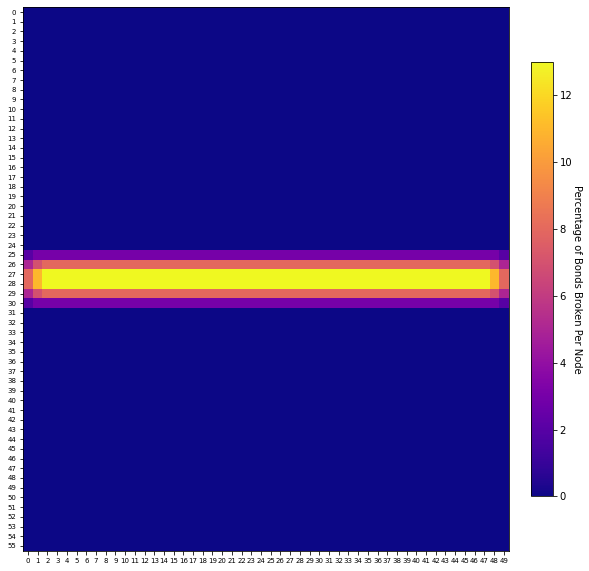

In [254]:
# Enhancing the visualization with additional parameters
plt.figure(figsize=(10, 10))
plt.imshow(grid_viz, cmap='plasma', interpolation='nearest')

# Adding a color bar with labels and title
cbar = plt.colorbar(fraction=0.046, pad=0.04, shrink=0.8)
cbar.set_label('Percentage of Bonds Broken Per Node', rotation=270, labelpad=10)


# Customizing ticks and grid
plt.xticks(ticks=np.arange(grid_viz.shape[1]), labels=[f'{i}' for i in range(grid_viz.shape[1])], fontsize=7)
plt.yticks(ticks=np.arange(grid_viz.shape[0]), labels=[f'{i}' for i in range(grid_viz.shape[0])], fontsize=7)

# Adding a grid for clarity
plt.grid(visible=False)

# Show the final plot
plt.show()


### Displacement Calculations

In [255]:
"""
    #Time stepping loop

    #Set current time
    
    #Enforce boundary conditions

    #Clear internal force vectors

    #Compute the internal force 

    #Compute the nodal acceleration

    #Compute the nodal velocity

    #Compute the new displacement

    #Compute stable time step

    #Compute damage


"""

'\n    #Time stepping loop\n\n    #Set current time\n    \n    #Enforce boundary conditions\n\n    #Clear internal force vectors\n\n    #Compute the internal force \n\n    #Compute the nodal acceleration\n\n    #Compute the nodal velocity\n\n    #Compute the new displacement\n\n    #Compute stable time step\n\n    #Compute damage\n\n\n'

Let's write the code for only one time step

In [ ]:
#Make temporary arrays
dispx = np.zeros_like(grid_viz)
dispy = np.zeros_like(grid_viz)
velx = np.zeros_like(grid_viz)
vely = np.zeros_like(grid_viz)
forcex = np.zeros_like(grid_viz)
forcey = np.zeros_like(grid_viz)


#Go through all the nodes

#Let's say we are in the first time step here.

#We enforce the boundary condition first

iteration = 1
current_time = iteration * del_T

#Enforce the boundary conditions

#We have displacement vector, therefore, we will have dispx and dispy
#Boundary condition is defined by velocity, hence, we can not use velocity value in displacement vector
#Hence, we will multiply the velocity vector by time, to get the displacement



In [514]:
#define the 3D array for the displacement of the nodes

dispx = np.zeros((time_steps, nx, total_nodes_in_ydir))     #Define the displacement in x direction
dispy = np.zeros((time_steps, nx, total_nodes_in_ydir))     #Define the displacement in y direction
vel = np.zeros((time_steps, nx, total_nodes_in_ydir))       #Define the velocity 

bforce = np.zeros((time_steps, nx, total_nodes_in_ydir))    #bforce will be defined in the loop
pforce1 = np.zeros((time_steps, nx, total_nodes_in_ydir))    #pforce will be defined in the loop
pforce2 = np.zeros((time_steps, nx, total_nodes_in_ydir))    #pforce will be defined in the loop
pforce_old = np.zeros((time_steps, nx, total_nodes_in_ydir))#will be defeind in the loop
acc1 = np.zeros((time_steps, nx, total_nodes_in_ydir))       #Acceleration will be defined in the loop
acc2 = np.zeros((time_steps, nx, total_nodes_in_ydir))       #Acceleration will be defined in the loop


total_internal_nodes = nx*ny                                #Number of nodes without boundary regions
poissonratio = 1/3            #Poisson ratio

In [515]:
dispy.shape

(10, 50, 56)

In [516]:
coord_array.shape

(50, 56)

In [501]:
top_nodes_x_index = [list[0] for list in list_top_nodes_index]
top_nodes_y_index = [list[1] for list in list_top_nodes_index]

btm_nodes_x_index = [list[0] for list in list_btm_nodes_index]
btm_nodes_y_index = [list[1] for list in list_btm_nodes_index]

internal_nodes_x_index = [list[0] for list in list_internal_nodes_index]
internal_nodes_y_index = [list[1] for list in list_internal_nodes_index]

#Loop through all the time_steps
for time_this_iteration in range(time_steps):

    #returns the time at current iteration
    time_elapsed = time_this_iteration * dt

    #Assign boundary condition to all the top nodes
    #We have all the nodes in top region with their coordinats stored at list_top_nodes
    
    for i in top_nodes_x_index:
        for j in top_nodes_y_index:
            dispy[time_this_iteration, i, j] = -20 * time_this_iteration * dt
            vel[time_this_iteration, i, j] = -20
    
    for i in btm_nodes_x_index:
        for j in btm_nodes_y_index:
            dispy[time_this_iteration, i, j] = 20 * time_this_iteration * dt
            vel[time_this_iteration, i, j] = 20

    for i in list_internal_nodes_index:

            #i is given by [i,j]
            #so we have the indices i,j for xi
            #find the coordinates of xi

            x_idx = i[0]
            y_idx = i[1]

            xloc_xi = coord_array[x_idx, y_idx][0]
            yloc_xi = coord_array[x_idx, y_idx][1]

            idx_xi = find_index_using_coords(index_coords_array, xloc_xi, yloc_xi)

            #Iterate over all the neighbors (family nodes) of xi
            for xp in neighbors_dict[idx_xi]:

                if idx_xi==xp:
                    break

                #Get the x & y coordinates for xp
                xloc_xp = index_coords_array[xp][1]             #Get x-coord for xp
                yloc_xp = index_coords_array[xp][2]             #Get y-coord for xp

                idist = np.sqrt((xloc_xp-xloc_xi)**2 
                                + (yloc_xp - yloc_xi)**2)
                
                #Get the i,j for xp
                xp_idx_x, xp_idx_y = convert(xp, nx, total_nodes_in_ydir)
                
                #get the displacement values for disp at xp
                dispx_xp = dispx[time_this_iteration, xp_idx_x, xp_idx_y]
                dispy_xp = dispy[time_this_iteration, xp_idx_x, xp_idx_y]

                #get the displacement values for disp at xp
                dispx_xi = dispx[time_this_iteration, i[0], i[1]]
                dispy_xi = dispy[time_this_iteration, i[0], i[1]]

                nlength = np.sqrt((xloc_xp+dispx_xp - xloc_xi - dispx_xi)**2 
                                  + (yloc_xp + dispy_xp - yloc_xi - dispy_xi)**2)
                
            if fail[i[0], i[1]] == 1:
                    dforce1 = c * (nlength-idist) / idist*vol*((xloc_xp+dispx_xp-xloc_xi-dispx_xi)/nlength)
                    dforce2 = c * (nlength-idist) / idist*vol*((yloc_xp+dispy_xp-yloc_xi-dispy_xi)/nlength)
            else:
                    dforce1 = 0
                    dforce2 = 0

            pforce1[time_this_iteration, i[0], i[1]] = pforce1[time_this_iteration, i[0], i[1]] + dforce1
            pforce2[time_this_iteration, i[0], i[1]] = pforce2[time_this_iteration, i[0], i[1]] + dforce2

    for i in list_internal_nodes_index:
        acc1[time_this_iteration, i[0], i[1]] = (pforce1[time_this_iteration, i[0], i[1]] + bforce[time_this_iteration, i[0], i[1]]) / rho
        acc2[time_this_iteration, i[0], i[1]] = (pforce2[time_this_iteration, i[0], i[1]] + bforce[time_this_iteration, i[0], i[1]]) / rho
        vel[time_this_iteration, i[0], i[1]] = vel[time_this_iteration, i[0], i[1]] + acc1[time_this_iteration, i[0], i[1]] *dt
        dispx[time_this_iteration, i[0], i[1]] = dispx[time_this_iteration, i[0], i[1]] + vel[time_this_iteration, i[0], i[1]] * dt
        dispy[time_this_iteration, i[0], i[1]] = dispy[time_this_iteration, i[0], i[1]] + vel[time_this_iteration, i[0], i[1]] * dt                     

In [503]:
disp_test = dispy[5,:,:]

In [ ]:
disp_test

In [ ]:
dispy

In [ ]:
list_internal_nodes_index

In [ ]:
pforce

In [460]:
vel.shape

(10, 50, 56)